In [1]:
from model import Wav2Vec2BertForCantonese
from transformers import Wav2Vec2BertProcessor, SeamlessM4TFeatureExtractor, Wav2Vec2CTCTokenizer, AddedToken
import librosa

In [2]:
model_id = "/home/pj24001684/ku40000295/jc/projects/wav2vec2bert-jyutping/checkpoints/iter3-checkpoint-4380"

tokenizer = Wav2Vec2CTCTokenizer(
    "vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|"
)
tone_tokenizer = Wav2Vec2CTCTokenizer(
    "tone_vocab.json",
    unk_token="[UNK]",
    pad_token="[PAD]",
    word_delimiter_token="|",
)

# fix token splitting problem
for key in tokenizer.get_vocab().keys():
    if key not in tokenizer.special_tokens_map.values():
        idx = tokenizer.get_vocab()[key]
        tokenizer._added_tokens_decoder[idx] = AddedToken(
            key, lstrip=False, rstrip=False
        )
for key in tone_tokenizer.get_vocab().keys():
    if key not in tone_tokenizer.special_tokens_map.values():
        idx = tone_tokenizer.get_vocab()[key]
        tone_tokenizer._added_tokens_decoder[idx] = AddedToken(
            key, lstrip=False, rstrip=False
        )
        
# load processor
feature_extractor = SeamlessM4TFeatureExtractor.from_pretrained(model_id)
processor = Wav2Vec2BertProcessor(
    feature_extractor=feature_extractor, tokenizer=tokenizer
)

model = Wav2Vec2BertForCantonese.from_pretrained(
    model_id,
    attention_dropout=0.2,
    hidden_dropout=0.2,
    feat_proj_dropout=0.0,
    mask_time_prob=0.0,
    layerdrop=0.0,
    add_adapter=True,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer),
).eval() # .cuda()

/home/pj24001684/ku40000295/venv/jc/lib64/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
import torch
import re

test1_audio = "/home/pj24001684/ku40000295/jc/projects/wav2vec2bert-jyutping/test2.wav"
test1_output = "maa4 maa1 go3 jiu4 jiu2 jiu4 jiu4 juk6 zeoi6 maa1 maa5 saang4 tau4 tau2 tau4 tau4 si6 dou6 hok6 hou2 hok6 saang1 hou3 hok6 hou2 hou2 sang1 wut6 hoeng1 gong2 dei6 tit3 maai5 hoeng1 gong2 dei6 dei6 tou4 gam3 daai6 tiu4 ge3 ze1 ze1 mei6 gin3 gwo3 wo4"

audio_input, _ = librosa.load(test1_audio, sr=16_000)
input_features = (
    processor(audio_input, return_tensors="pt", sampling_rate=16_000)
    .input_features[0]
    .unsqueeze(0)
)  # .cuda()
jyutping_labels = tokenizer.encode(
    " ".join(
        [t for t in tokenizer.tokenize(re.sub(r"\d", "", test1_output)) if t != "|"]
    )
)
tone_labels = tone_tokenizer.encode(re.sub(r"[^1-6\s]+", "", test1_output))
print(tone_labels)
print(tokenizer.decode(jyutping_labels))
print(tone_tokenizer.decode(tone_labels), re.sub(r"[^1-6\s]+", "", test1_output))
# jyutping_labels = tokenizer.encode("maa maa go jiu jiu jiu jiu juk zeoi maa maa saang tau tau tau tau si dou hok hou hok saang hou hok hou hou sang wut hoeng gong dei tit maai hoeng gong dei dei tou gam daai tiu ge ze ze mei gin gwo wo")
# tone_labels = tone_tokenizer.encode("4 1 3 4 2 4 4 6 6 1 5 4 4 2 4 4 6 6 6 2 6 1 3 6 2 2 1 6 1 2 6 3 5 1 2 6 6 4 3 6 4 3 1 1 6 3 3 4")
jyutping_labels = torch.LongTensor(jyutping_labels).unsqueeze(0)
tone_labels = torch.LongTensor(tone_labels).unsqueeze(0)

with torch.inference_mode():
    outputs = model(
        input_features, jyutping_labels=jyutping_labels, tone_labels=tone_labels
    )

# test1 loss: 29.4785
jyutping_logits = outputs.jyutping_logits
tone_logits = outputs.tone_logits
jyutping_pred_ids = torch.argmax(jyutping_logits, dim=-1)
tone_pred_ids = torch.argmax(tone_logits, dim=-1)
jyutping_pred = tokenizer.batch_decode(jyutping_pred_ids)
tone_pred = tone_tokenizer.batch_decode(tone_pred_ids)

print(outputs.jyutping_loss, outputs.tone_loss, jyutping_pred, tone_pred)

[6, 2, 3, 2, 5, 2, 6, 2, 4, 2, 6, 2, 6, 2, 8, 2, 8, 2, 3, 2, 7, 2, 6, 2, 6, 2, 4, 2, 6, 2, 6, 2, 8, 2, 8, 2, 8, 2, 4, 2, 8, 2, 3, 2, 5, 2, 8, 2, 4, 2, 4, 2, 3, 2, 8, 2, 3, 2, 4, 2, 8, 2, 5, 2, 7, 2, 3, 2, 4, 2, 8, 2, 8, 2, 6, 2, 5, 2, 8, 2, 6, 2, 5, 2, 3, 2, 3, 2, 8, 2, 5, 2, 5, 2, 6]
m aa m aa g o j iu j iu j iu j iu j uk z eoi m aa m aa s aang t au t au t au t au s i d ou h ok h ou h ok s aang h ou h ok h ou h ou s ang w ut h oeng g ong d ei t it m aai h oeng g ong d ei d ei t ou g am d aai t iu g e z e z e m ei g in gw o w o
4 1 3 4 2 4 4 6 6 1 5 4 4 2 4 4 6 6 6 2 6 1 3 6 2 2 1 6 1 2 6 3 5 1 2 6 6 4 3 6 4 3 1 1 6 3 3 4 4 1 3 4 2 4 4 6 6 1 5 4 4 2 4 4 6 6 6 2 6 1 3 6 2 2 1 6 1 2 6 3 5 1 2 6 6 4 3 6 4 3 1 1 6 3 3 4
tensor(0.0001) tensor(0.0126) ['m aa m aa g o j iu j iu j iu j iu j uk z eoi m aa m aa s aang t au t au t au t au s i d ou h ok h ou h ok s aang h ou h ok h ou h ou s ang w ut h oeng g ong d ei t it m aai h oeng g ong d ei d ei t ou g am d aai t iu g e z e z e m ei g in gw 

In [ ]:
# test2_audio = "/home/pj24001684/ku40000295/jc/projects/wav2vec2bert-jyutping/sambert_tts/0000.wav"
test2_audio = "/home/pj24001684/ku40000295/jc/projects/wav2vec2bert-jyutping/test2.wav"

audio_input, _ = librosa.load(test2_audio, sr=16_000)
input_features = processor(audio_input, return_tensors="pt", sampling_rate=16_000).input_features[0].unsqueeze(0) #.cuda()
output = model.inference(input_features=input_features, processor=processor, tone_tokenizer=tone_tokenizer)

print(output)

# "/home/pj24001684/ku40000295/jc/projects/wav2vec2bert-jyutping/test2.wav"
# iter2: maa4 maa1 go3 jiu4 jiu2 jiu4 jiu4 juk6 zeoi6 maa1 maa4 saan4 tau4 tau2 tau4 tau4 si6 dou6 hok6 hou2 hok6 saang1 hou6 hok6 hou2 hou2 sang1 wut6 hoeng1 gong2 dei6 tit3 maai5 hoeng1 gong2 dei6 dei6 to4 gam3 daai6 tiu4 ge3 ze1 ze1 mei6 gin3 gwo3 wo4
# iter3: maa4 maa1 go3 jiu4 jiu2 jiu4 jiu4 juk6 zeoi6 maa1 maa5 saang4 tau4 tau2 tau4 tau4 si6 dou6 hok6 hou2 hok6 saang1 hou3 hok6 hou2 hou2 sang1 wut6 hoeng1 gong2 dei6 tit3 maai5 hoeng1 gong2 dei6 dei6 tou4 gam3 daai6 tiu4 ge3 ze1 ze1 mei6 gin3 gwo3 wo4

('ngoi6 zi1 gung1 si1', tensor([[[ -2.1729,  -4.4786,   4.8352,  ...,   5.7642,  -4.0204,  -2.9925],
         [ -5.8445, -10.9695,  35.5088,  ...,   2.6810,  -9.8087,  -9.4435],
         [ -5.2459,  -9.1556,  27.5204,  ...,   1.9842,  -9.8423,  -9.7504],
         ...,
         [ -2.3323,  -5.1817,  27.5859,  ...,   5.6572,  -5.5512,  -6.5736],
         [ -2.5633,  -6.0044,  30.1224,  ...,   4.5027,  -5.6453,  -6.9127],
         [ -1.3713,  -5.3249,  -1.9377,  ...,   0.9222,  -4.6194,  -5.1831]]],
       grad_fn=<ViewBackward0>), tensor([[[ -5.8520,  -7.9612,  -3.1362,  -5.3710,   0.2570,  -0.5745,  -0.0983,
            0.3568,  15.8619],
         [ 11.1885, -10.3925,  25.9119, -16.6599,  -6.2418,  -8.1642,  -5.5409,
           -5.3339,  13.6900],
         [  7.2702,  -8.3080,  30.5968, -13.9944,  -6.9478,  -7.0505,  -5.3182,
           -4.9480,   9.6888],
         [  8.3617,  -6.7421,  27.5813, -10.4564,  -7.5243,  -7.0144,  -4.2018,
           -5.9823,  10.2378],
         [  7.6282,  

In [11]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

emissions = torch.log_softmax(output[2], dim=-1)

labels = tone_tokenizer.get_vocab()
emission = emissions[0].cpu().detach()

print(labels)

{'[PAD]': 0, '[UNK]': 1, '|': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '<s>': 9, '</s>': 10}


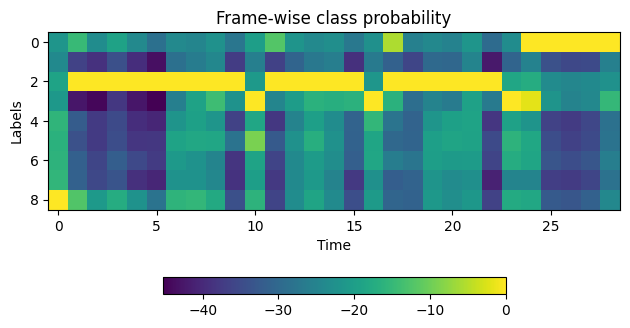

In [12]:
import matplotlib.pyplot as plt

def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(emission.T)
    ax.set_title("Frame-wise class probability")
    ax.set_xlabel("Time")
    ax.set_ylabel("Labels")
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()

plot()

In [13]:
# We enclose the transcript with space tokens, which represent SOS and EOS.
transcript = "|6|1|1|1|"
dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    trellis = torch.zeros((num_frame, num_tokens))
    trellis[1:, 0] = torch.cumsum(emission[1:, blank_id], 0)
    trellis[0, 1:] = -float("inf")
    trellis[-num_tokens + 1 :, 0] = float("inf")

    for t in range(num_frame - 1):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens[1:]],
        )
    return trellis


trellis = get_trellis(emission, tokens)

[('|', 2), ('6', 8), ('|', 2), ('1', 3), ('|', 2), ('1', 3), ('|', 2), ('1', 3), ('|', 2)]


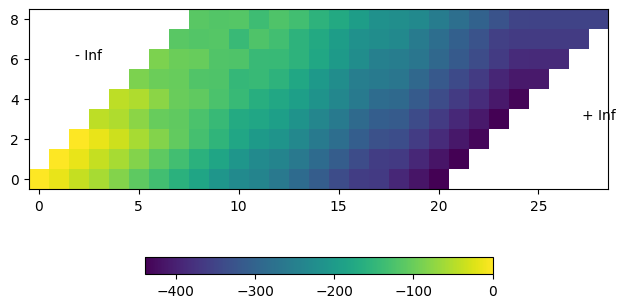

In [14]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(trellis.T, origin="lower")
    ax.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
    ax.annotate("+ Inf", (trellis.size(0) - trellis.size(1) / 5, trellis.size(1) / 3))
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

In [17]:
from dataclasses import dataclass

@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    t, j = trellis.size(0) - 1, trellis.size(1) - 1

    path = [Point(j, t, emission[t, blank_id].exp().item())]
    while j > 0:
        # Should not happen but just in case
        assert t > 0

        # 1. Figure out if the current position was stay or change
        # Frame-wise score of stay vs change
        p_stay = emission[t - 1, blank_id]
        p_change = emission[t - 1, tokens[j]]

        # Context-aware score for stay vs change
        stayed = trellis[t - 1, j] + p_stay
        changed = trellis[t - 1, j - 1] + p_change

        # Update position
        t -= 1
        if changed > stayed:
            j -= 1

        # Store the path with frame-wise probability.
        prob = (p_change if changed > stayed else p_stay).exp().item()
        path.append(Point(j, t, prob))

    # Now j == 0, which means, it reached the SoS.
    # Fill up the rest for the sake of visualization
    while t > 0:
        prob = emission[t - 1, blank_id].exp().item()
        path.append(Point(j, t - 1, prob))
        t -= 1

    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

Point(token_index=0, time_index=0, score=0.9999994039535522)
Point(token_index=1, time_index=1, score=4.033865366181999e-07)
Point(token_index=1, time_index=2, score=7.402500140640811e-11)
Point(token_index=1, time_index=3, score=4.498179606571284e-09)
Point(token_index=1, time_index=4, score=3.847243357224528e-11)
Point(token_index=1, time_index=5, score=1.0)
Point(token_index=2, time_index=6, score=3.57515961280086e-11)
Point(token_index=2, time_index=7, score=1.869889659777968e-11)
Point(token_index=2, time_index=8, score=8.423139661317691e-07)
Point(token_index=3, time_index=9, score=1.0)
Point(token_index=4, time_index=10, score=0.9998852014541626)
Point(token_index=5, time_index=11, score=5.56058239453705e-06)
Point(token_index=5, time_index=12, score=3.2009114803166483e-10)
Point(token_index=5, time_index=13, score=3.6174820083889614e-11)
Point(token_index=5, time_index=14, score=1.165888080523203e-10)
Point(token_index=5, time_index=15, score=0.9999998807907104)
Point(token_ind

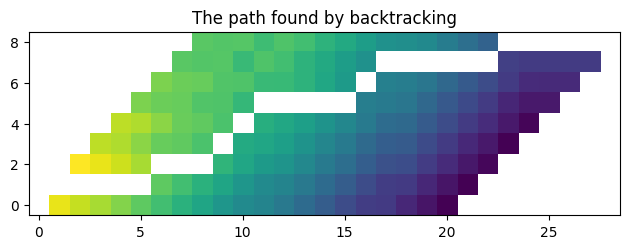

In [19]:
def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path.T, origin="lower")
    plt.title("The path found by backtracking")
    plt.tight_layout()


plot_trellis_with_path(trellis, path)

In [20]:
# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

|	(1.00): [    0,     1)
6	(0.20): [    1,     6)
|	(0.00): [    6,     9)
1	(1.00): [    9,    10)
|	(1.00): [   10,    11)
1	(0.20): [   11,    16)
|	(1.00): [   16,    17)
1	(0.17): [   17,    23)
|	(0.81): [   23,    29)


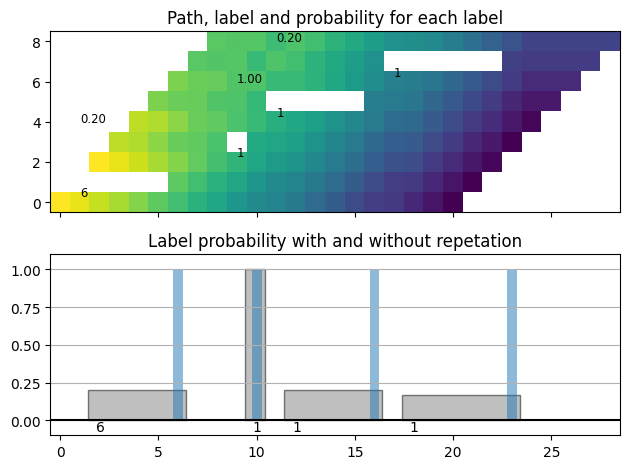

In [21]:
def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07))
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.grid(True, axis="y")
    ax2.set_ylim(-0.1, 1.1)
    fig.tight_layout()


plot_trellis_with_segments(trellis, segments, transcript)

In [22]:
# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

6	(0.20): [    1,     6)
1	(1.00): [    9,    10)
1	(0.20): [   11,    16)
1	(0.17): [   17,    23)


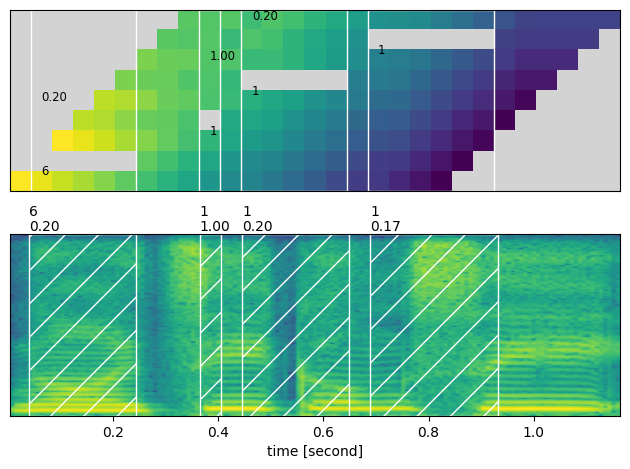

In [28]:

def plot_alignments(trellis, segments, word_segments, waveform, sample_rate=16_000):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1)

    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")
    ax1.set_facecolor("lightgray")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvspan(word.start - 0.5, word.end - 0.5, edgecolor="white", facecolor="none")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    # The original waveform
    ratio = len(audio_input) / sample_rate / trellis.size(0)
    ax2.specgram(waveform, Fs=sample_rate)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, facecolor="none", edgecolor="white", hatch="/")
        ax2.annotate(f"{word.score:.2f}", (x0, sample_rate * 0.51), annotation_clip=False)

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, sample_rate * 0.55), annotation_clip=False)
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    fig.tight_layout()


plot_alignments(
    trellis,
    segments,
    word_segments,
    audio_input,
)

In [32]:
import IPython.display as ipd

def display_segment(i):
    ratio = len(audio_input) / trellis.size(0)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    print(f"{word.label} ({word.score:.2f}): {x0 / 16_000:.3f} - {x1 / 16_000:.3f} sec")
    segment = audio_input[x0:x1]
    return ipd.Audio(segment, rate=16_000)

In [36]:
display_segment(3)

1 (0.17): 0.689 - 0.932 sec


In [ ]:
import torch
from ctc_forced_aligner import (
    load_audio,
    load_alignment_model,
    generate_emissions,
    preprocess_text,
    get_alignments,
    get_spans,
    postprocess_results,
)
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 1
text = "我决定去找一颗红豆"


alignment_model, alignment_tokenizer = load_alignment_model(
    device=device,
    dtype=torch.float16 if device == "cuda" else torch.float32,
)
audio_path = "/home/pj24001684/ku40000295/jc/projects/wav2vec2bert-jyutping/test3.mp3"
audio_waveform = load_audio(audio_path, alignment_model.dtype, alignment_model.device)

emissions, stride = generate_emissions(
    alignment_model, audio_waveform, batch_size=batch_size
)

tokens_starred, text_starred = preprocess_text(
    text,
    romanize=True,
    language="zh",
)

segments, scores, blank_token = get_alignments(
    emissions,
    tokens_starred,
    alignment_tokenizer,
)

spans = get_spans(tokens_starred, segments, blank_token)

word_timestamps = postprocess_results(text_starred, spans, stride, scores)

In [11]:
word_timestamps

[{'start': 0.16,
  'end': 2.58,
  'text': '我决定去找一颗红豆',
  'score': -21.148080825805664}]